In [4]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
import torch

# Set the max_rows option to 100
# pd.set_option('display.max_rows', None)

/home/filip/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing

In [2]:
# Load the dataset
df_patients = pd.read_csv(filepath_or_buffer="data/patient_sentiment.csv", names=['ID', 'Post', 'Label'], skiprows=[0])
df_nurse_doctors = pd.read_csv(filepath_or_buffer="data/hcp_sentiment.csv", names=['ID', 'Post', 'Label', 'Stakeholder'], skiprows=[0])

In [3]:
df_nurse_doctors.drop(columns=['ID', 'Stakeholder'], inplace=True)
df_nurse_doctors.head()

,Post,Label
0,Delicate for my beautiful young patient 💎💎\n....,C
1,When is the last time you talked about things ...,E
2,💥 Use coupon arorainsta10 for 10% off any cour...,C
3,To all my incredible physician colleagues on t...,E
4,WE DID IT!!! 🎉 Now presenting the @maimohealth...,E


In [4]:
df_patients.drop(columns=['ID'], inplace=True)
df_patients.head()

,Post,Label
0,“Confidence is preparation. Everything else is...,D
1,It’s safe to say this chick had a great birthd...,D
2,So today I did a thing…\nI went to work in nat...,C
3,Has to be done.....\n\nHappy November 9 Day!!!...,E
4,I have a telephone appointment on the 19th of ...,A


In [5]:
df_nurse_doctors['Label'].value_counts()

Label
C                        3307
D                        3034
E                        2672
B                         571
A                         141
0                           6
E - very positive           3
D - slightly positive       2
A - very negative           1
C - neutral                 1
Name: count, dtype: int64

In [6]:
df_nurse_doctors.replace({
    "D - slightly positive": "Slightly positive",
    "A - very negative": "Extremely negative",
    "B - negative": "Slightly negative",
    "C - neutral": "Neutral",
    "E - very positive": "Extremely positive",
    "D": "Slightly positive",
    "A": "Extremely negative",
    "B": "Slightly negative",
    "C": "Neutral",
    "E": "Extremely positive"
}, inplace=True)

# Remove the random 0 value
df_nurse_doctors = df_nurse_doctors[df_nurse_doctors["Label"] != '0']

df_nurse_doctors['Label'].value_counts()


Label
Neutral               3308
Slightly positive     3036
Extremely positive    2675
Slightly negative      571
Extremely negative     142
Name: count, dtype: int64

In [7]:
df_nurse_doctors['Label'].value_counts().sum()

9732

In [8]:
df_patients['Label'].value_counts()

Label
D                        2938
E                        2783
C                        2677
B                        1181
A                         372
0                          78
A - very negative           2
D - slightly positive       2
E -very positive            1
C - neutral                 1
Name: count, dtype: int64

In [9]:
df_patients.replace({
    "D - slightly positive": "Slightly positive",
    "A - very negative": "Extremely negative",
    "B - negative": "Slightly negative",
    "C - neutral": "Neutral",
    "E -very positive": "Extremely positive",
    "D": "Slightly positive",
    "A": "Extremely negative",
    "B": "Slightly negative",
    "C": "Neutral",
    "E": "Extremely positive"
}, inplace=True)

# Remove the random 0 value
df_patients = df_patients[df_patients["Label"] != '0']

df_patients['Label'].value_counts().sum()

9957

In [10]:
df_patients['Label'].value_counts().sum()

9957

In [11]:
df_nurse_doctors.dropna(subset=["Label"], inplace=True)
print(f"There are {df_nurse_doctors['Label'].isna().sum()} nan values in nurses and doctors.")

There are 0 nan values in nurses and doctors.


In [12]:
print(f"There are {df_patients['Label'].isna().sum()} nan values in patients.")

There are 0 nan values in patients.


In [13]:
merged_df = pd.concat([df_patients, df_nurse_doctors], ignore_index=True)

In [14]:
merged_df["Label"].value_counts()

Label
Neutral               5986
Slightly positive     5976
Extremely positive    5459
Slightly negative     1752
Extremely negative     516
Name: count, dtype: int64

In [15]:
merged_df.isna().sum()

Post     0
Label    0
dtype: int64

In [5]:
import re
import emoji
import unicodedata

def clean_text(text, remove_dots=True):
    # Remove emojis
    text = emoji.demojize(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove tags (e.g., @username)
    text = re.sub(r'@\w+', '', text)

    # Remove newlines
    text = re.sub(r'\n', ' ', text)

    # Remove lines with dashes
    text = re.sub(r'[-]{2,}', '', text)

    # Remove all punctuations except the full stop (.)
    text = re.sub(r'[^\w\s.]', '', text)

    if remove_dots:
        text = re.sub(r'\.', '', text)
    
    # Convert to normal unicode text
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # Convert to lowercase (optional, depending on your use case)
    text = text.lower()

    text = text.strip()

    return text

In [17]:
merged_df['Post'] = merged_df['Post'].apply(clean_text)

# Remove the empty rows
def is_all_spaces(s):
    return s.isspace()

merged_df = merged_df[~merged_df['Post'].apply(is_all_spaces)]

In [18]:
# Define a function to check if a string has one word
def has_one_word(s):
    return len(s.split()) < 6

# Remove rows with one word or an empty string in the 'Post' column
merged_df = merged_df[~merged_df['Post'].apply(lambda x: len(x) <= 1 or has_one_word(x))]

In [19]:
merged_df.to_csv("data/merged_sentiment.csv", index=False)

In [20]:
merged_df["Label"].value_counts()

Label
Slightly positive     5753
Extremely positive    5329
Neutral               5272
Slightly negative     1699
Extremely negative     512
Name: count, dtype: int64

In [25]:
mix1 = pd.read_csv(filepath_or_buffer="data/sentiment mixed - OUTPUT.csv")
mix2 = pd.read_csv(filepath_or_buffer="data/sentimentmixedpart2 - sentimentmixedpart2.csv")

In [26]:
mix1 = mix1[['TEXT', 'LABEL']]
mix2 = mix2[['TEXT', 'LABEL']]
mix1.rename(columns={'TEXT': 'Post', 'LABEL': 'Label'}, inplace=True)
mix2.rename(columns={'TEXT': 'Post', 'LABEL': 'Label'}, inplace=True)

In [27]:
mix = pd.concat([mix1, mix2], ignore_index=True)

In [28]:
mix["Label"].value_counts()

Label
C                        3147
D                        2714
E                        2218
B                         766
A                         160
0                          78
C - neutral                 4
E -very positive            1
D - slightly positive       1
B - slightly negative       1
Name: count, dtype: int64

In [31]:
mix.dropna(inplace=True)
mix.isna().sum()

Post     0
Label    0
dtype: int64

In [32]:
mix["Post"] = mix["Post"].apply(clean_text)

In [33]:
mix.replace({
    "D - slightly positive": "Slightly positive",
    "A - very negative": "Extremely negative",
    "B - slightly negative": "Slightly negative",
    "C - neutral": "Neutral",
    "E -very positive": "Extremely positive",
    "D": "Slightly positive",
    "A": "Extremely negative",
    "B": "Slightly negative",
    "C": "Neutral",
    "E": "Extremely positive"
}, inplace=True)

# Remove the random 0 value
mix = mix[mix["Label"] != '0']

In [34]:
mix['Post'] = mix['Post'].apply(clean_text)

# Remove the empty rows
def is_all_spaces(s):
    return s.isspace()

mix = mix[~mix['Post'].apply(is_all_spaces)]

In [35]:
# Define a function to check if a string has one word
def has_one_word(s):
    return len(s.split()) < 6

# Remove rows with one word or an empty string in the 'Post' column
mix = mix[~mix['Post'].apply(lambda x: len(x) <= 1 or has_one_word(x))]

In [36]:
mix['Label'].value_counts()

Label
Slightly positive     2446
Neutral               2076
Extremely positive    2064
Slightly negative      721
Extremely negative     152
Name: count, dtype: int64

In [37]:
mask = mix['Label'].isin(['Slightly negative', 'Extremely negative'])
selected_rows = mix[mask]

In [40]:
merged_df = pd.concat([merged_df, selected_rows], ignore_index=True)

In [41]:
merged_df['Label'].value_counts()

Label
Slightly positive     5753
Extremely positive    5329
Neutral               5272
Slightly negative     2420
Extremely negative     664
Name: count, dtype: int64

In [42]:
merged_df.to_csv("data/merged_sentiment.csv", index=False)

# Training

In [1]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'bert-sentiment-analysis.ipynb'

import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import torch

# Set the max_rows option to 100
# pd.set_option('display.max_rows', None)

/home/filip/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
merged_df = pd.read_csv("data/merged_sentiment.csv")

In [4]:
merged_df.head()

,Post,Label
0,confidence is preparation everything else is b...,Slightly positive
1,its safe to say this chick had a great birthda...,Slightly positive
2,so today i did a thing i went to work in natur...,Neutral
3,has to be done happy november 9 day and if y...,Extremely positive
4,i have a telephone appointment on the 19th of ...,Extremely negative


Funkcija u py file koji vraca object koji sadrzi i int i string labele.
U istom folderu staviti model i py skriptu; preprocessing file takoder za input stringove

In [3]:
# merged_df = merged_df[~merged_df['Label'].isin(['Slightly negative', 'Extremely negative'])]
merged_df["Label"].value_counts()

Label
Slightly positive     5630
Extremely positive    5209
Neutral               5003
Slightly negative     2306
Extremely negative     628
Name: count, dtype: int64

In [4]:
# Set up the RoBERTa tokenizer and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'prajjwal1/bert-mini'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)  # 5 is the number of sentiment classes A to E
model.to(device=device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, e

In [5]:
# Define a custom dataset class to prepare the data for training
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.label_map = {
            'Extremely negative': 0,
            'Slightly negative': 1,
            'Neutral': 2,
            'Slightly positive': 3,
            'Extremely positive': 4
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['Post'])
        label = self.data.iloc[idx]['Label']

        label_id = self.label_map[label]

        # Tokenize the text and convert it to input features for the model
        inputs = self.tokenizer(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,  # Truncate sequences longer than max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': inputs['input_ids'].squeeze().to(device),
            'attention_mask': inputs['attention_mask'].squeeze().to(device),
            'labels': torch.tensor(label_id, dtype=torch.long).to(device)
        }

In [6]:
# Splitting the data into train and validation sets
df_train, df_val = train_test_split(merged_df, test_size=0.3, shuffle=True)
df_val, df_test = train_test_split(df_val, test_size=0.5, shuffle=True)

In [34]:
df_test['Label'].value_counts()

Label
Slightly positive     802
Neutral               792
Extremely positive    782
Slightly negative     352
Extremely negative     89
Name: count, dtype: int64

In [14]:
batch_size = 32

# Create the training, validation and test datasets
train_dataset = CustomDataset(df_train, tokenizer, max_length=512)
val_dataset = CustomDataset(df_val, tokenizer, max_length=512)
test_dataset = CustomDataset(df_test, tokenizer, max_length=512)

# # Set up the DataLoader for training and validation
# train_loader = DataLoader(train_dataset, batch_size=batch_size)#, collate_fn=data_collator, pin_memory=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)#, collate_fn=data_collator, pin_memory=False)

In [15]:
def compute_metrics(predictions):
    labels = predictions.label_ids
    preds = predictions.predictions.argmax(-1)

    accuracy = accuracy_score(y_true=labels, y_pred=preds)
    # recall = recall_score(y_true=labels, y_pred=preds, average='macro')
    # precision = precision_score(y_true=labels, y_pred=preds, average='macro')
    # f1 = f1_score(y_true=labels, y_pred=preds, average='macro')

    # # return {
    #     'accuracy': accuracy,
    #     'precision': precision,
    #     'recall': recall,
    #     'f1': f1
    # }
    return {
        'accuracy': accuracy
    }

In [ ]:
# Set up the training arguments for the Trainer
training_args = TrainingArguments(
    output_dir='./results',        # Directory to save the model checkpoints and results
    num_train_epochs=10,            # Number of training epochs
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # warmup_steps=500,              # Number of warmup steps for learning rate scheduler
    save_strategy='steps',
    evaluation_strategy='steps',
    logging_strategy='epoch',
    logging_dir='./logs',          # Directory for storing logs
    load_best_model_at_end=True,   # Load the best model when finished training (default metric is loss)
    report_to='wandb',
    run_name='bert-mini',
    lr_scheduler_type='cosine',
    metric_for_best_model='accuracy',
    greater_is_better=True,
    eval_steps=100,
    save_steps=1000
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [18]:
# Start training
trainer.train()

/home/filip/.local/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: fbutic. Use `wandb login --relogin` to force relogin


                                                  
  2%|▏         | 101/4110 [00:20<1:53:09,  1.69s/it]

{'eval_loss': 1.2770520448684692, 'eval_accuracy': 0.44921875, 'eval_runtime': 5.1536, 'eval_samples_per_second': 546.414, 'eval_steps_per_second': 17.075, 'epoch': 0.24}


                                                    
  5%|▍         | 201/4110 [00:41<1:52:28,  1.73s/it]

{'eval_loss': 1.1814552545547485, 'eval_accuracy': 0.5081676136363636, 'eval_runtime': 5.2594, 'eval_samples_per_second': 535.42, 'eval_steps_per_second': 16.732, 'epoch': 0.49}


                                                    
  7%|▋         | 301/4110 [01:01<1:51:28,  1.76s/it]

{'eval_loss': 1.1305463314056396, 'eval_accuracy': 0.5241477272727273, 'eval_runtime': 5.3414, 'eval_samples_per_second': 527.2, 'eval_steps_per_second': 16.475, 'epoch': 0.73}


                                                    
 10%|▉         | 401/4110 [01:21<1:51:46,  1.81s/it]

{'eval_loss': 1.0868393182754517, 'eval_accuracy': 0.5465198863636364, 'eval_runtime': 5.4788, 'eval_samples_per_second': 513.986, 'eval_steps_per_second': 16.062, 'epoch': 0.97}


 10%|█         | 412/4110 [01:23<11:12,  5.50it/s]  

{'loss': 1.2113, 'learning_rate': 4.877641290737884e-05, 'epoch': 1.0}


                                                  
 12%|█▏        | 501/4110 [01:43<1:56:28,  1.94s/it]

{'eval_loss': 1.08271324634552, 'eval_accuracy': 0.5390625, 'eval_runtime': 5.8666, 'eval_samples_per_second': 480.002, 'eval_steps_per_second': 15.0, 'epoch': 1.22}


                                                    
 15%|█▍        | 601/4110 [02:06<2:02:52,  2.10s/it]

{'eval_loss': 1.0821701288223267, 'eval_accuracy': 0.5486505681818182, 'eval_runtime': 6.428, 'eval_samples_per_second': 438.081, 'eval_steps_per_second': 13.69, 'epoch': 1.46}


                                                    
 17%|█▋        | 701/4110 [02:29<1:48:51,  1.92s/it]

{'eval_loss': 1.0829503536224365, 'eval_accuracy': 0.5383522727272727, 'eval_runtime': 5.8516, 'eval_samples_per_second': 481.236, 'eval_steps_per_second': 15.039, 'epoch': 1.7}


                                                    
 19%|█▉        | 801/4110 [02:53<1:51:41,  2.03s/it]

{'eval_loss': 1.0582178831100464, 'eval_accuracy': 0.5490056818181818, 'eval_runtime': 6.1898, 'eval_samples_per_second': 454.944, 'eval_steps_per_second': 14.217, 'epoch': 1.95}


 20%|██        | 823/4110 [02:57<08:59,  6.09it/s]  

{'loss': 1.0065, 'learning_rate': 4.522542485937369e-05, 'epoch': 2.0}


                                                  
 22%|██▏       | 900/4110 [03:16<09:10,  5.83it/s]

{'eval_loss': 1.101697325706482, 'eval_accuracy': 0.5390625, 'eval_runtime': 6.1438, 'eval_samples_per_second': 458.352, 'eval_steps_per_second': 14.323, 'epoch': 2.19}


                                                    
 24%|██▍       | 1000/4110 [03:39<09:08,  5.67it/s]

{'eval_loss': 1.1019550561904907, 'eval_accuracy': 0.5447443181818182, 'eval_runtime': 5.9628, 'eval_samples_per_second': 472.263, 'eval_steps_per_second': 14.758, 'epoch': 2.43}


                                                     
 27%|██▋       | 1100/4110 [04:03<09:41,  5.18it/s]

{'eval_loss': 1.0698715448379517, 'eval_accuracy': 0.5600142045454546, 'eval_runtime': 6.1225, 'eval_samples_per_second': 459.944, 'eval_steps_per_second': 14.373, 'epoch': 2.68}


                                                     
 29%|██▉       | 1201/4110 [04:27<1:36:49,  2.00s/it]

{'eval_loss': 1.0873967409133911, 'eval_accuracy': 0.5529119318181818, 'eval_runtime': 6.0622, 'eval_samples_per_second': 464.517, 'eval_steps_per_second': 14.516, 'epoch': 2.92}


 30%|███       | 1234/4110 [04:32<08:23,  5.71it/s]  

{'loss': 0.8889, 'learning_rate': 3.969463130731183e-05, 'epoch': 3.0}


                                                   
 32%|███▏      | 1301/4110 [04:50<1:35:35,  2.04s/it]

{'eval_loss': 1.115875244140625, 'eval_accuracy': 0.5379971590909091, 'eval_runtime': 6.2501, 'eval_samples_per_second': 450.554, 'eval_steps_per_second': 14.08, 'epoch': 3.16}


                                                     
 34%|███▍      | 1401/4110 [05:13<1:28:35,  1.96s/it]

{'eval_loss': 1.111769437789917, 'eval_accuracy': 0.5522017045454546, 'eval_runtime': 5.9425, 'eval_samples_per_second': 473.877, 'eval_steps_per_second': 14.809, 'epoch': 3.41}


                                                     
 36%|███▋      | 1500/4110 [05:37<07:21,  5.91it/s]

{'eval_loss': 1.1033838987350464, 'eval_accuracy': 0.5482954545454546, 'eval_runtime': 6.2876, 'eval_samples_per_second': 447.866, 'eval_steps_per_second': 13.996, 'epoch': 3.65}


                                                     
 39%|███▉      | 1601/4110 [06:02<1:26:21,  2.07s/it]

{'eval_loss': 1.1147011518478394, 'eval_accuracy': 0.5500710227272727, 'eval_runtime': 6.3252, 'eval_samples_per_second': 445.203, 'eval_steps_per_second': 13.913, 'epoch': 3.89}


 40%|████      | 1644/4110 [06:10<07:09,  5.74it/s]  

{'loss': 0.7915, 'learning_rate': 3.272542485937369e-05, 'epoch': 4.0}


                                                   
 41%|████▏     | 1701/4110 [06:26<1:20:10,  2.00s/it]

{'eval_loss': 1.1327109336853027, 'eval_accuracy': 0.5511363636363636, 'eval_runtime': 6.0728, 'eval_samples_per_second': 463.708, 'eval_steps_per_second': 14.491, 'epoch': 4.14}


                                                     
 44%|████▍     | 1801/4110 [06:51<1:22:28,  2.14s/it]

{'eval_loss': 1.1673911809921265, 'eval_accuracy': 0.5504261363636364, 'eval_runtime': 6.4818, 'eval_samples_per_second': 434.449, 'eval_steps_per_second': 13.577, 'epoch': 4.38}


                                                     
 46%|████▌     | 1900/4110 [07:15<06:11,  5.94it/s]

{'eval_loss': 1.1522353887557983, 'eval_accuracy': 0.5539772727272727, 'eval_runtime': 6.2226, 'eval_samples_per_second': 452.547, 'eval_steps_per_second': 14.142, 'epoch': 4.62}


                                                     
 49%|████▊     | 2000/4110 [07:40<06:38,  5.29it/s]

{'eval_loss': 1.1686183214187622, 'eval_accuracy': 0.5568181818181818, 'eval_runtime': 6.3475, 'eval_samples_per_second': 443.639, 'eval_steps_per_second': 13.864, 'epoch': 4.87}


 50%|█████     | 2056/4110 [07:50<06:02,  5.66it/s]  

{'loss': 0.6918, 'learning_rate': 2.5e-05, 'epoch': 5.0}


                                                   
 51%|█████     | 2101/4110 [08:05<1:09:34,  2.08s/it]

{'eval_loss': 1.1925467252731323, 'eval_accuracy': 0.5504261363636364, 'eval_runtime': 6.3408, 'eval_samples_per_second': 444.108, 'eval_steps_per_second': 13.878, 'epoch': 5.11}


                                                     
 54%|█████▎    | 2201/4110 [08:29<1:04:52,  2.04s/it]

{'eval_loss': 1.2190907001495361, 'eval_accuracy': 0.5422585227272727, 'eval_runtime': 6.1643, 'eval_samples_per_second': 456.82, 'eval_steps_per_second': 14.276, 'epoch': 5.35}


                                                     
 56%|█████▌    | 2301/4110 [08:53<1:02:33,  2.08s/it]

{'eval_loss': 1.223894715309143, 'eval_accuracy': 0.5543323863636364, 'eval_runtime': 6.2923, 'eval_samples_per_second': 447.53, 'eval_steps_per_second': 13.985, 'epoch': 5.6}


                                                     
 58%|█████▊    | 2401/4110 [09:19<1:00:21,  2.12s/it]

{'eval_loss': 1.2457656860351562, 'eval_accuracy': 0.5465198863636364, 'eval_runtime': 6.401, 'eval_samples_per_second': 439.93, 'eval_steps_per_second': 13.748, 'epoch': 5.84}


 60%|██████    | 2467/4110 [09:31<04:50,  5.66it/s]  

{'loss': 0.6011, 'learning_rate': 1.7274575140626318e-05, 'epoch': 6.0}


                                                   
 61%|██████    | 2501/4110 [09:44<57:11,  2.13s/it]

{'eval_loss': 1.2528018951416016, 'eval_accuracy': 0.5482954545454546, 'eval_runtime': 6.479, 'eval_samples_per_second': 434.633, 'eval_steps_per_second': 13.582, 'epoch': 6.08}


                                                   
 63%|██████▎   | 2601/4110 [10:09<51:31,  2.05s/it]

{'eval_loss': 1.2712754011154175, 'eval_accuracy': 0.5387073863636364, 'eval_runtime': 6.2116, 'eval_samples_per_second': 453.346, 'eval_steps_per_second': 14.167, 'epoch': 6.33}


                                                   
 66%|██████▌   | 2701/4110 [10:33<47:14,  2.01s/it]

{'eval_loss': 1.2612977027893066, 'eval_accuracy': 0.5436789772727273, 'eval_runtime': 6.1004, 'eval_samples_per_second': 461.612, 'eval_steps_per_second': 14.425, 'epoch': 6.57}


                                                   
 68%|██████▊   | 2801/4110 [10:58<44:35,  2.04s/it]

{'eval_loss': 1.276380181312561, 'eval_accuracy': 0.5465198863636364, 'eval_runtime': 6.2212, 'eval_samples_per_second': 452.643, 'eval_steps_per_second': 14.145, 'epoch': 6.81}


 70%|███████   | 2877/4110 [11:11<03:28,  5.92it/s]

{'loss': 0.5412, 'learning_rate': 1.0305368692688174e-05, 'epoch': 7.0}


                                                   
 71%|███████   | 2901/4110 [11:22<41:15,  2.05s/it]

{'eval_loss': 1.2853761911392212, 'eval_accuracy': 0.5490056818181818, 'eval_runtime': 6.2217, 'eval_samples_per_second': 452.612, 'eval_steps_per_second': 14.144, 'epoch': 7.06}


                                                   
 73%|███████▎  | 3000/4110 [11:46<03:12,  5.76it/s]

{'eval_loss': 1.2975761890411377, 'eval_accuracy': 0.5482954545454546, 'eval_runtime': 5.9756, 'eval_samples_per_second': 471.251, 'eval_steps_per_second': 14.727, 'epoch': 7.3}


                                                   
 75%|███████▌  | 3101/4110 [12:10<33:34,  2.00s/it]

{'eval_loss': 1.308334469795227, 'eval_accuracy': 0.5465198863636364, 'eval_runtime': 6.1049, 'eval_samples_per_second': 461.272, 'eval_steps_per_second': 14.415, 'epoch': 7.54}


                                                   
 78%|███████▊  | 3201/4110 [12:34<30:04,  1.98s/it]

{'eval_loss': 1.3115029335021973, 'eval_accuracy': 0.546875, 'eval_runtime': 6.0506, 'eval_samples_per_second': 465.411, 'eval_steps_per_second': 14.544, 'epoch': 7.79}


 80%|████████  | 3289/4110 [12:49<02:16,  6.02it/s]

{'loss': 0.4949, 'learning_rate': 4.7745751406263165e-06, 'epoch': 8.0}


                                                   
 80%|████████  | 3301/4110 [12:58<27:39,  2.05s/it]

{'eval_loss': 1.3177894353866577, 'eval_accuracy': 0.5447443181818182, 'eval_runtime': 6.2692, 'eval_samples_per_second': 449.181, 'eval_steps_per_second': 14.037, 'epoch': 8.03}


                                                   
 83%|████████▎ | 3401/4110 [13:22<24:04,  2.04s/it]

{'eval_loss': 1.3195072412490845, 'eval_accuracy': 0.5443892045454546, 'eval_runtime': 6.1862, 'eval_samples_per_second': 455.208, 'eval_steps_per_second': 14.225, 'epoch': 8.27}


                                                   
 85%|████████▌ | 3501/4110 [13:47<21:16,  2.10s/it]

{'eval_loss': 1.3268485069274902, 'eval_accuracy': 0.5450994318181818, 'eval_runtime': 6.4129, 'eval_samples_per_second': 439.113, 'eval_steps_per_second': 13.722, 'epoch': 8.52}


                                                   
 88%|████████▊ | 3601/4110 [14:11<17:05,  2.01s/it]

{'eval_loss': 1.3284344673156738, 'eval_accuracy': 0.5447443181818182, 'eval_runtime': 6.1135, 'eval_samples_per_second': 460.617, 'eval_steps_per_second': 14.394, 'epoch': 8.76}


 90%|█████████ | 3699/4110 [14:29<01:10,  5.82it/s]

{'loss': 0.4672, 'learning_rate': 1.2235870926211619e-06, 'epoch': 9.0}


                                                   
 90%|█████████ | 3701/4110 [14:36<14:08,  2.07s/it]

{'eval_loss': 1.3335808515548706, 'eval_accuracy': 0.5433238636363636, 'eval_runtime': 6.3017, 'eval_samples_per_second': 446.867, 'eval_steps_per_second': 13.965, 'epoch': 9.0}


                                                   
 92%|█████████▏| 3801/4110 [15:01<10:55,  2.12s/it]

{'eval_loss': 1.3336431980133057, 'eval_accuracy': 0.5422585227272727, 'eval_runtime': 6.4163, 'eval_samples_per_second': 438.884, 'eval_steps_per_second': 13.715, 'epoch': 9.25}


                                                   
 95%|█████████▍| 3901/4110 [15:27<07:42,  2.21s/it]

{'eval_loss': 1.3345439434051514, 'eval_accuracy': 0.5433238636363636, 'eval_runtime': 6.7777, 'eval_samples_per_second': 415.482, 'eval_steps_per_second': 12.984, 'epoch': 9.49}


                                                   
 97%|█████████▋| 4000/4110 [15:52<00:21,  5.22it/s]

{'eval_loss': 1.3349590301513672, 'eval_accuracy': 0.5419034090909091, 'eval_runtime': 6.6848, 'eval_samples_per_second': 421.255, 'eval_steps_per_second': 13.164, 'epoch': 9.73}


                                                   
100%|█████████▉| 4100/4110 [16:19<00:02,  4.75it/s]

{'eval_loss': 1.3349391222000122, 'eval_accuracy': 0.5419034090909091, 'eval_runtime': 6.6907, 'eval_samples_per_second': 420.88, 'eval_steps_per_second': 13.153, 'epoch': 9.98}


100%|██████████| 4110/4110 [16:21<00:00,  4.19it/s]

{'loss': 0.4581, 'learning_rate': 0.0, 'epoch': 10.0}
{'train_runtime': 984.1665, 'train_samples_per_second': 133.544, 'train_steps_per_second': 4.176, 'train_loss': 0.7152696372818773, 'epoch': 10.0}


TrainOutput(global_step=4110, training_loss=0.7152696372818773, metrics={'train_runtime': 984.1665, 'train_samples_per_second': 133.544, 'train_steps_per_second': 4.176, 'train_loss': 0.7152696372818773, 'epoch': 10.0})

In [19]:
# Save the trained model
trainer.save_model('./trained_model')

In [20]:
trainer.evaluate()

100%|██████████| 88/88 [00:05<00:00, 17.03it/s]


{'eval_loss': 1.1686183214187622,
 'eval_accuracy': 0.5568181818181818,
 'eval_runtime': 5.2469,
 'eval_samples_per_second': 536.695,
 'eval_steps_per_second': 16.772,
 'epoch': 10.0}

In [29]:
preds = trainer.predict(test_dataset=test_dataset)


100%|██████████| 89/89 [00:05<00:00, 17.55it/s]


In [ ]:
trainer.predict()

In [30]:
def compute_accuracy(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": (preds == labels).mean()}

compute_accuracy(preds)

{'accuracy': 0.5839545615903443}

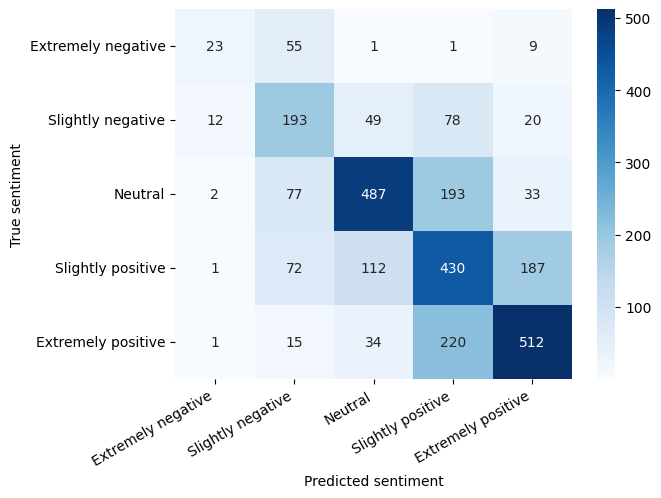

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

# Get the true labels and predicted labels from the predictions
true_labels = preds.label_ids
predicted_labels = preds.predictions.argmax(-1)

class_names = ['Extremely negative', 'Slightly negative', 'Neutral', 'Slightly positive', 'Extremely positive']
# Compute the confusion matrix from the true labels and predicted labels
cm = confusion_matrix(true_labels, predicted_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [37]:
# Get the number of correctly predicted examples per class
correct_per_class = cm.diagonal()

print(correct_per_class)

# Get the total number of examples per class
total_per_class = cm.sum(axis=1)

print(total_per_class)

# Compute the per-class accuracy
accuracy_per_class = correct_per_class / total_per_class

# Print the per-class accuracy
print(accuracy_per_class)

[ 23 193 487 430 512]
[ 89 352 792 802 782]
[0.25842697 0.54829545 0.61489899 0.5361596  0.65473146]


In [32]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                    precision    recall  f1-score   support

Extremely negative       0.59      0.26      0.36        89
 Slightly negative       0.47      0.55      0.51       352
           Neutral       0.71      0.61      0.66       792
 Slightly positive       0.47      0.54      0.50       802
Extremely positive       0.67      0.65      0.66       782

          accuracy                           0.58      2817
         macro avg       0.58      0.52      0.54      2817
      weighted avg       0.60      0.58      0.59      2817



# Inference

In [8]:
inp = merged_df['Post'].loc[0]
print(inp)

confidence is preparation everything else is beyond your control


In [2]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")
tokenizer.save_pretrained('./trained_model/tokenizer/')

('./trained_model/tokenizer/tokenizer_config.json',
 './trained_model/tokenizer/special_tokens_map.json',
 './trained_model/tokenizer/vocab.txt',
 './trained_model/tokenizer/added_tokens.json',
 './trained_model/tokenizer/tokenizer.json')

In [12]:
# Replace 'model_name_or_path' with the path to the saved model directory or the name of the pretrained model
model_name_or_path = './trained_model'  # Example: './saved_model'

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)

# Optional: If you want to use a specific device (e.g., 'cuda' or 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Example input text for inference
input_text = "This is an example sentence for inference."

# Tokenize the input text
inputs = tokenizer.encode_plus(
    input_text,
    None,
    add_special_tokens=True,
    padding='max_length',
    max_length=128,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors='pt'
)

# Move the inputs to the specified device
inputs = {key: val.to(device) for key, val in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted logits and probabilities
logits = outputs.logits
probabilities = torch.softmax(logits, dim=-1)

# Get the predicted class (index of the class with the highest probability)
predicted_class = torch.argmax(probabilities, dim=-1).item()

# Map the predicted class index to the corresponding label
label2id = tokenizer.get_vocab()
print(label2id)
id2label = {v: k for k, v in label2id.items()}
predicted_label = id2label[predicted_class]

# Example output
print("Input Text:", input_text)
print("Predicted Class:", predicted_class)
print("Predicted Label:", predicted_label)
print("Predicted Probabilities:", probabilities)

{'pavel': 18635, 'cruisers': 16722, '##overs': 24302, 'hermit': 24308, '##nage': 27031, '[unused811]': 816, '##hand': 11774, 'approval': 6226, 'compressed': 16620, 'tamil': 6008, '##rbin': 27366, 'journal': 3485, 'likes': 7777, '##љ': 29762, 'scratch': 11969, 'bone': 5923, 'delegation': 10656, '...': 2133, 'fined': 16981, 'rus': 22949, '1922': 4798, 'lengthy': 12401, '##pal': 12952, '##eza': 28640, 'air': 2250, 'friedman': 18486, '[unused795]': 800, 'extant': 12905, 'bowler': 14999, '##aina': 27971, 'tony': 4116, 'comparing': 13599, 'ufo': 24321, 'stepfather': 21481, '##hers': 22328, 'missy': 25019, 'judged': 13224, 'within': 2306, 'lydia': 14076, 'reacting': 24868, 'anonymous': 10812, 'adolph': 28564, 'allmusic': 10477, 'gr': 24665, 'figure': 3275, '##tel': 9834, 'seemingly': 9428, 'had': 2018, 'increased': 3445, '##non': 8540, '##ᄐ': 30003, '真': 1921, '##eck': 11012, 'scotia': 9676, 'th': 16215, 'differed': 19541, 'hesse': 16399, '##umble': 26607, 'fades': 26784, '38th': 22051, 'form

### Q&A

Why did I have to insert:

`self._pin_memory = False` 

in the dataloader.py file in function _next_data(self) at line 678?
Why did it always default to True?
Why did I get this error:

`RuntimeError:cannot pin 'torch.cuda.LongTensor' only CPU tensors can pinned`

and what does it mean?